In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

import glob
import keras
from keras import layers
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import Add, Activation, Lambda, BatchNormalization, Concatenate, Dropout, Input, Embedding, Dot, Reshape, Dense, Flatten, Multiply

import tensorflow as tf
# Inspirations:
# https://www.kaggle.com/code/chaitanya99/recommendation-system-cf-anime

2023-01-22 20:57:21.810525: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-22 20:57:23.120486: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/alepmaros/miniconda3/envs/tf2/lib/:/home/alepmaros/miniconda3/envs/tf2/lib/
2023-01-22 20:57:23.120586: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/alepmaros/miniconda3/envs/tf2/lib/:/home

In [2]:
tf.config.experimental.list_physical_devices('GPU')

2023-01-22 20:57:24.148962: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-22 20:57:24.185553: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-22 20:57:24.185746: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
CUR_INPUT = "/mnt/d/datasets/anime2020/"
INPUT_DIR = "/mnt/d/datasets/anime2020/animelist_400+/*.parquet"

print()

In [4]:
rating_df = pd.read_parquet(
    glob.glob(INPUT_DIR)[0],
    columns=["user", "anime", "rating"]
)

rating_df

,user,anime,rating
0,27687,10633,0.8
1,47271,382,0.3
2,83098,6953,0.0
3,66134,115,0.0
4,46121,9255,0.8
...,...,...,...
71418109,57926,11639,0.3
71418110,6231,7976,0.6
71418111,57075,8496,0.7
71418112,30486,2301,0.0


In [5]:
n_users = rating_df["user"].nunique()
n_animes = rating_df["anime"].nunique()

In [6]:
rating_df.memory_usage(index=False, deep=True)

user      285672456
anime     285672456
rating    285672456
dtype: int64

In [7]:
print('Avg', np.mean(rating_df['rating']))

Avg 0.40477988


In [8]:
X = rating_df[['user', 'anime']].values
y = rating_df["rating"]

In [9]:
# Split
test_set_size = 10000 #10k for test set
train_indices = rating_df.shape[0] - test_set_size 

X_train, X_test, y_train, y_test = (
    X[:train_indices],
    X[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

print('> Train set ratings: {}'.format(len(y_train)))
print('> Test set ratings: {}'.format(len(y_test)))

> Train set ratings: 71408114
> Test set ratings: 10000


In [10]:
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

In [11]:
# del rating_df

In [12]:
# Embedding layers

# def RecommenderNet():
#     embedding_size = 64
    
#     user = Input(name = 'user', shape = [1])
#     user_embedding = Embedding(name = 'user_embedding',
#                                input_dim = n_users, 
#                                output_dim = embedding_size)(user)
    
#     anime = Input(name = 'anime', shape = [1])
#     anime_embedding = Embedding(name = 'anime_embedding',
#                                 input_dim = n_animes, 
#                                 output_dim = embedding_size)(anime)
    
#     #x = Concatenate()([user_embedding, anime_embedding])
#     x = Dot(name = 'dot_product', normalize = True, axes = 2)([user_embedding, anime_embedding])
#     x = Flatten()(x)
        
#     x = Dense(1, kernel_initializer='he_normal')(x)
#     x = BatchNormalization()(x)
#     x = Activation("sigmoid")(x)
    
#     model = Model(inputs=[user, anime], outputs=x)
#     model.compile(loss='binary_crossentropy', metrics=["mae", "mse"], optimizer='Adam')
    
#     return model

# model = RecommenderNet()
# model.summary()


def RecommenderNet():
    embedding_size = 64
    
    user = Input(name = 'user', shape = [1])
    user_embedding = Embedding(name = 'user_embedding',
                               input_dim = n_users, 
                               output_dim = embedding_size)(user)
    
    anime = Input(name = 'anime', shape = [1])
    anime_embedding = Embedding(name = 'anime_embedding',
                                input_dim = n_animes, 
                                output_dim = embedding_size)(anime)
 
    x = Multiply()([user_embedding, anime_embedding])
    x = Dense(32, kernel_initializer='he_normal')(x)

    x2 = Concatenate()([user_embedding, anime_embedding])
    x2 = Dropout(.3)(x2)
    x2 = Dense(32, kernel_initializer='he_normal', activation="relu")(x2)
    x2 = Dropout(.3)(x2)
    x2 = Dense(32, kernel_initializer='he_normal', activation="relu")(x2)
    
    x3 = Dot(name = 'dot_product', normalize = True, axes = 2)([user_embedding, anime_embedding])
    
    
    x = Concatenate()([x, x2, x3])
    x = Dropout(.3)(x)
    x = Dense(32, kernel_initializer='he_normal', activation="relu")(x)

    x = Dense(1, kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation("sigmoid")(x)
    
    model = Model(inputs=[user, anime], outputs=x)
    model.compile(loss='binary_crossentropy', metrics=["mae", "mse"], optimizer='Adam')
    
    return model

model = RecommenderNet()
model.summary()

2023-01-22 20:57:30.651036: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 anime (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 user_embedding (Embedding)     (None, 1, 64)        5865024     ['user[0][0]']                   
                                                                                                  
 anime_embedding (Embedding)    (None, 1, 64)        1123840     ['anime[0][0]']                  
                                                                                              

2023-01-22 20:57:30.652577: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-22 20:57:30.652756: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-22 20:57:30.652915: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-22 20:57:31.765001: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-22 20:57:31.765712: I tensorflow/compile

Total params: 6,998,277
Trainable params: 6,998,275
Non-trainable params: 2
__________________________________________________________________________________________________


In [13]:
# Callbacks
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, ReduceLROnPlateau

start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.00005
batch_size = 1000

rampup_epochs = 5
sustain_epochs = 0
exp_decay = .8

def lrfn(epoch):
    if epoch < rampup_epochs:
        return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
    elif epoch < rampup_epochs + sustain_epochs:
        return max_lr
    else:
        return (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr


lr_callback = LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=0)

checkpoint_filepath = './weights.h5'

model_checkpoints = ModelCheckpoint(filepath=checkpoint_filepath,
                                        save_weights_only=True,
                                        monitor='val_loss',
                                        mode='min',
                                        save_best_only=True)

early_stopping = EarlyStopping(patience = 3, monitor='val_loss', 
                               mode='min', restore_best_weights=True)

my_callbacks = [
    model_checkpoints,
    lr_callback,
    early_stopping,   
]

In [14]:
history = model.fit(
    x=X_train_array,
    y=y_train,
    batch_size=batch_size,
    epochs=20,
    verbose=1,
    validation_data=(X_test_array, y_test),
    callbacks=my_callbacks
)

2023-01-22 20:57:33.636390: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 571264912 exceeds 10% of free system memory.
2023-01-22 20:57:33.728269: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 571264912 exceeds 10% of free system memory.


Epoch 1/20


2023-01-22 20:57:35.167537: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 571264912 exceeds 10% of free system memory.
2023-01-22 20:57:35.250297: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 571264912 exceeds 10% of free system memory.
2023-01-22 20:57:37.105969: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 571264912 exceeds 10% of free system memory.
2023-01-22 20:57:38.258618: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-01-22 20:57:38.520902: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x1ff8aeb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-01-22 20:57:38.520934: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2023-01-22 20:57:38.548860: I tensorflow/compiler/mli

71409/71409 [==============================] - 757s 11ms/step - loss: 0.6227 - mae: 0.3104 - mse: 0.1258 - val_loss: 0.5604 - val_mae: 0.2620 - val_mse: 0.0969 - lr: 1.0000e-05
Epoch 2/20
71409/71409 [==============================] - 725s 10ms/step - loss: 0.5455 - mae: 0.2432 - mse: 0.0940 - val_loss: 0.5457 - val_mae: 0.2493 - val_mse: 0.0923 - lr: 1.8000e-05
Epoch 3/20
71409/71409 [==============================] - 729s 10ms/step - loss: 0.5373 - mae: 0.2352 - mse: 0.0910 - val_loss: 0.5373 - val_mae: 0.2415 - val_mse: 0.0895 - lr: 2.6000e-05
Epoch 4/20
71409/71409 [==============================] - 744s 10ms/step - loss: 0.5289 - mae: 0.2276 - mse: 0.0877 - val_loss: 0.5248 - val_mae: 0.2264 - val_mse: 0.0852 - lr: 3.4000e-05
Epoch 5/20
71409/71409 [==============================] - 720s 10ms/step - loss: 0.5128 - mae: 0.2133 - mse: 0.0814 - val_loss: 0.5097 - val_mae: 0.2094 - val_mse: 0.0796 - lr: 4.2000e-05
Epoch 6/20
71409/71409 [==============================] - 744s 10ms/ste

In [15]:
# model.load_weights(checkpoint_filepath)

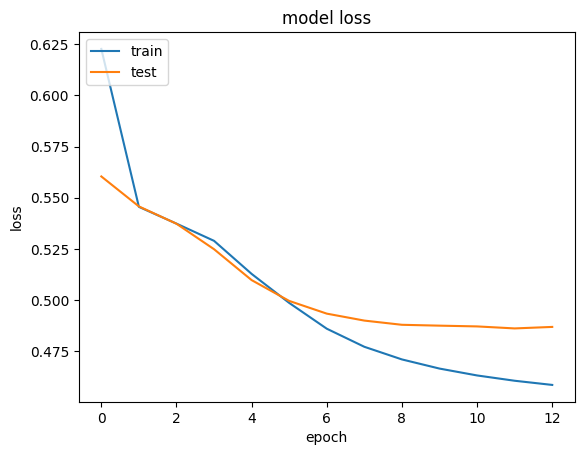

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(history.history["loss"][0:-2])
plt.plot(history.history["val_loss"][0:-2])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [17]:
def extract_weights(name, model):
    weight_layer = model.get_layer(name)
    weights = weight_layer.get_weights()[0]
    weights = weights / np.linalg.norm(weights, axis = 1).reshape((-1, 1))
    return weights

anime_embeddings = extract_weights('anime_embedding', model)
user_embeddings = extract_weights('user_embedding', model)

In [18]:
import os
import pickle

with open(os.path.join(CUR_INPUT, "anime_embeddings.pickle"), "wb") as f:
    pickle.dump(anime_embeddings, f)

with open(os.path.join(CUR_INPUT, "user_embeddings.pickle"), "wb") as f:
    pickle.dump(user_embeddings, f)

In [19]:
np.savetxt(os.path.join(CUR_INPUT,"anime_embeddings.tsv"), anime_embeddings, delimiter="\t")

In [20]:
df_anime = pd.read_csv(os.path.join(CUR_INPUT, "anime.csv"), low_memory=True)
df_anime = df_anime.rename(columns={"MAL_ID": "anime_id"})

In [21]:
with open(os.path.join(CUR_INPUT, "animelist_400+", "anime2anime_encoded.pickle"), "rb") as input_file:
    anime2anime_encoded = pickle.load(input_file)

In [22]:
df_anime["anime_id_mapped"] = df_anime["anime_id"].map(anime2anime_encoded, na_action="ignore")
df_anime = df_anime.dropna(subset=["anime_id_mapped"])
df_anime["anime_id_mapped"] = df_anime["anime_id_mapped"].astype(int)

In [23]:
df_anime.sort_values("anime_id_mapped")[["Name"]].to_csv(os.path.join(CUR_INPUT,"anime.tsv"), sep="\t", index=False, header=False)


In [24]:
df_anime.drop_duplicates(subset=["anime_id"])

,anime_id,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,anime_id_mapped
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0,0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0,1
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,75651.0,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0,2
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,...,4806.0,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0,3
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,...,529.0,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17557,48481,Daomu Biji Zhi Qinling Shen Shu,Unknown,"Adventure, Mystery, Supernatural",Unknown,盗墓笔记之秦岭神树,ONA,Unknown,"Apr 4, 2021 to ?",Unknown,...,Unknown,Unknown,1.0,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,17555
17558,48483,Mieruko-chan,Unknown,"Comedy, Horror, Supernatural",Unknown,見える子ちゃん,TV,Unknown,2021 to ?,Unknown,...,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,17556
17559,48488,Higurashi no Naku Koro ni Sotsu,Unknown,"Mystery, Dementia, Horror, Psychological, Supe...",Higurashi:When They Cry – SOTSU,ひぐらしのなく頃に卒,TV,Unknown,"Jul, 2021 to ?",Summer 2021,...,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,17557
17560,48491,Yama no Susume: Next Summit,Unknown,"Adventure, Slice of Life, Comedy",Unknown,ヤマノススメ Next Summit,TV,Unknown,Unknown,Unknown,...,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,17558
